### #import thư viện cần thiết

In [10]:
import re# thư viện để python làm việc với biểu thức chính quy
import csv# thư viện để xử lí file .csv
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize
from pyvi import ViUtils 

### # ghi dữ liệu sang một file mới
### # loại bỏ stopword, kí tự, viết hoa
### # kiểm tra xem có comment hoặc label nào bị trống không

In [3]:
# đọc dữ liệu từ file gốc và sau đó loại bỏ stopwords và lưu lại vào file ra
input_file_path = 'raw_data.csv'  # File CSV cần xử lý
output_file_path = 'processed_data.csv'       # File CSV đầu ra
# Hàm đọc danh sách stopwords từ file
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())  # Đọc từng dòng và lưu vào set
    return stopwords
# Lấy danh sách stopwords từ file
stopwords = load_stopwords('vietnamese_stopwords.txt')
# Hàm làm sạch văn bản
def clean_text(text):
    # Chuyển tất cả chữ về dạng viết thường
    text = text.lower()
    # Loại bỏ emoji, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^\w\sáàạảãạăắằặẳẵâấầậẩẫéèẹẻẽêếềệểễíìịỉĩóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữýỳýỵỷỹđ]', '', text)
    # Loại bỏ stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text
# Đọc dữ liệu từ file CSV
try:
    with open(input_file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data1 = list(reader)  # Đọc toàn bộ dữ liệu từ file CSV
except FileNotFoundError:
    print(f"Không tìm thấy file: {input_file_path}")
    exit()
except csv.Error:
    print(f"Lỗi khi đọc file CSV: {input_file_path}")
    exit()
# Lọc và xử lý các mục comment, kiểm tra label và chỉ ghi lại những phần hợp lệ
processed_data1 = []
empty_rows = []  # Danh sách lưu dòng có dữ liệu trống
for index, item in enumerate(data1):
    comment = item.get('Comment', '').strip()
    label = item.get('Label', '').strip()
    # Kiểm tra dòng nào có dữ liệu bị trống
    if not comment or not label:
        empty_rows.append(index + 1)  # Lưu chỉ mục dòng (bắt đầu từ 1)
        continue
    # Xử lý comment
    cleaned_comment = clean_text(comment)
    processed_data1.append({'Comment': cleaned_comment, 'Label': label})
# Báo các dòng có dữ liệu bị trống
if empty_rows:
    print(f"Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': {empty_rows}")
# Ghi lại dữ liệu đã xử lý vào file CSV mới
try:
    with open(output_file_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['Comment', 'Label'])
        writer.writeheader()  # Ghi tiêu đề cột
        writer.writerows(processed_data1)  # Ghi dữ liệu
    print(f"Dữ liệu đã được ghi vào {output_file_path}")
except IOError:
    print(f"Không thể ghi dữ liệu vào file {output_file_path}")

Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': [2401, 2868]
Dữ liệu đã được ghi vào processed_data.csv


In [4]:
# phân loại từ cơ bản để xem có bao nhiêu từ hơn 400 từ
def classify_comments_by_length(csv_file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(csv_file_path)  
    # Kiểm tra xem cột 'comment' có tồn tại trong dữ liệu không
    if 'Comment' not in df.columns:
        raise ValueError("File CSV không chứa cột 'comment'")  
    # Hàm để đếm số lượng từ trong một comment
    def count_words(text):
        if isinstance(text, str):  # Kiểm tra xem text có phải là chuỗi không
            return len(text.split())
        return 0  
    # Phân loại thành hai nhóm: nhóm có trên 500 từ và nhóm có dưới 400 từ
    group_above_400 = df[df['Comment'].apply(count_words) > 400]
    group_below_400 = df[df['Comment'].apply(count_words) <= 400]  
    # In ra số lượng dòng trong mỗi nhóm
    print(f"Số lượng comment có hơn 400 từ: {len(group_above_400)}")
    print(f"Số lượng comment có 400 từ trở xuống: {len(group_below_400)}")   
    return group_above_400, group_below_400
# Đường dẫn tới file CSV của bạn
csv_file_path = 'processed_data.csv'
# Gọi hàm để phân loại các comment
group_above_500, group_below_500 = classify_comments_by_length(csv_file_path)
# In ra ví dụ cho mỗi nhóm
print("\nMột số ví dụ trong nhóm có hơn 400 từ:")
print(group_above_500.head())
print("\nMột số ví dụ trong nhóm có dưới 400 từ:")
print(group_below_500.head())


Số lượng comment có hơn 500 từ: 16
Số lượng comment có 500 từ trở xuống: 8063

Một số ví dụ trong nhóm có hơn 500 từ:
                                                Comment     Label
232   điên có đôi lời tựa của phần này có lẽ không h...  positive
239   với mình nếu tách những cảnh tưởng tượng ra kh...  positive
1336  giờ chưa từng phân tích phim hay bình luận suy...  negative
1380  về điểm khen mình không kiến còn về phần chê b...  negative
1386  có lẽ là câu chuyện quan điểm cá nhân mình khô...  positive

Một số ví dụ trong nhóm có dưới 500 từ:
                                             Comment     Label
0  p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...   neutral
1  phần 2 gần là 1 phần bôi nhọ phần 1 ai lại có ...  negative
2  năm nay kiểu gì toàn bom tấn thành bom xịt phi...  negative
3  đúng là cảm xúc các đoạn cao trào vẫn làm chưa...   neutral
4           phim khúc cuối nó dở 1 cái phim việt nam  negative


In [5]:
data = pd.read_csv('processed_data.csv')
data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,phần 2 gần là 1 phần bôi nhọ phần 1 ai lại có ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt phi...,negative
3,đúng là cảm xúc các đoạn cao trào vẫn làm chưa...,neutral
4,phim khúc cuối nó dở 1 cái phim việt nam,negative


### #Lọc comment và label

In [6]:
st_data =pd.DataFrame({'Comment': data['Comment'],'Label': data['Label']})
st_data = st_data.dropna()
st_data = st_data.reset_index(drop=True)
st_data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,phần 2 gần là 1 phần bôi nhọ phần 1 ai lại có ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt phi...,negative
3,đúng là cảm xúc các đoạn cao trào vẫn làm chưa...,neutral
4,phim khúc cuối nó dở 1 cái phim việt nam,negative


In [7]:
#đếm số lượng các nhãn
import pandas as pd
def count_labels_in_csv(file_path, label_column):
    try:
        # Đọc file CSV
        data = pd.read_csv(file_path)
        # Kiểm tra cột label có tồn tại không
        if label_column not in data.columns:
            print(f"Cột '{label_column}' không tồn tại trong file CSV.")
            return
        # Đếm số lượng xuất hiện của mỗi nhãn
        label_counts = data[label_column].value_counts()
        # In kết quả
        print("Số lượng các nhãn trong cột '{}' là:".format(label_column))
        for label, count in label_counts.items():
            print(f"{label}: {count}")
    except FileNotFoundError:
        print("File không tồn tại. Vui lòng kiểm tra đường dẫn.")
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
# Ví dụ sử dụng
file_path = "processed_data.csv"  # Thay đường dẫn đến file CSV của bạn
label_column = "Label"  # Thay tên cột Label của bạn
count_labels_in_csv(file_path, label_column)


Số lượng các nhãn trong cột 'Label' là:
neutral: 2735
negative: 2725
positive: 2619


### # Tạo một bản sao không có dấu, tokenization & lưu tạm

In [8]:
input_comment = st_data['Comment'].values
input_label = st_data['Label'].values
label_dictionary ={'positive':2,'neutral':1,'negative':0}
input_pre =[]
label_accent =[]
for idx, dt in enumerate(input_comment):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))# phần này là phần đã loại bỏ dấu
    input_text_pre_accent =ViTokenizer.tokenize(input_text_pre)# tokenization cho văn bản có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)# tokenization cho văn bản đã loại bỏ dấu
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_accent.append(input_label[idx])
    label_accent.append(input_label[idx])

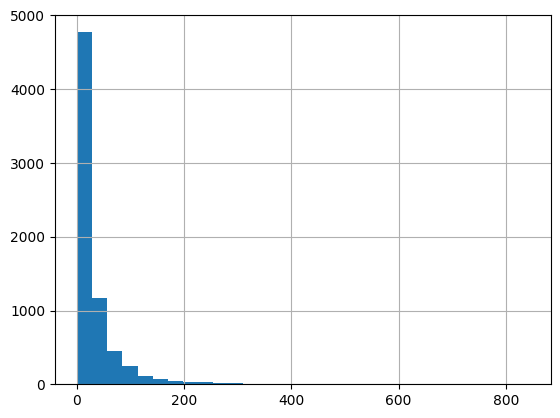

In [12]:
# lấy thông số và kiểm tra tần xuất
seq_len =[len(i.split())for i in input_pre[0:7000]]
pd.Series(seq_len).hist(bins =30)
plt.show()


In [11]:
# Chuyển đổi nhãn thành số và dạng one_hot coding
label_idx = [label_dictionary[i] for i in label_accent]
label_tf = to_categorical(label_idx, num_classes=3)
def save_processed_data(input_texts, labels, file_name):
    data = pd.DataFrame({'text': input_texts, 'label': labels})
    data.to_csv(file_name, index=False)
    print(f"Saved raw data to {file_name}")
save_processed_data(input_pre, label_accent, "processed_data.csv")
# Tạo tokenizer và xử lý văn bản
tokenizer_data = Tokenizer(oov_token='<OOV>', split=' ')
tokenizer_data.fit_on_texts(input_pre)
# Chuyển văn bản thành các chuỗi số và padding các chuỗi số
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=400)
# Lưu tokenizer đã huấn luyện vào file pickle
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
print("comment data.shape: ", vec_data.shape)
# Tính lại data_voca_size từ tokenizer
data_voca_size = len(tokenizer_data.word_index) + 1
print("data_voca_size: ", data_voca_size)
# Chia tập dữ liệu thành train, validation, và test
x_train, x_temp, y_train, y_temp = train_test_split(vec_data, label_tf, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
print("training sample: ", len(x_train))
print("validation sample: ", len(x_val))
print("test sample: ", len(x_test))
# Lưu dữ liệu đã tokenized vào các file CSV
def save_tokenized_data(input_data, labels, file_name):
    data = pd.DataFrame({'text': input_data, 'label': labels})
    data.to_csv(file_name, index=False)
    print(f"Saved tokenized data to {file_name}")
# Lưu dữ liệu train, validation, và test đã tokenized
save_tokenized_data(input_pre[:len(x_train)], label_accent[:len(x_train)], "training_data_tokenized.csv")
save_tokenized_data(input_pre[len(x_train):len(x_train) + len(x_val)], label_accent[len(x_train):len(x_train) + len(x_val)], "val_data_tokenized.csv")
save_tokenized_data(input_pre[len(x_train) + len(x_val):], label_accent[len(x_train) + len(x_val):], "test_data_tokenized.csv")
# Lưu dữ liệu đã xử lý vào CSV
def save_processed_data(features, labels, file_name):
    data = pd.DataFrame(features)
    labels = pd.DataFrame(labels, columns=[f"label_{i}" for i in range(labels.shape[1])])
    combined = pd.concat([data, labels], axis=1)
    combined.to_csv(file_name, index=False)
    print(f"Saved processed data to {file_name}")
save_processed_data(x_train, y_train, "training_data_processed.csv")
save_processed_data(x_val, y_val, "val_data_processed.csv")
save_processed_data(x_test, y_test, "test_data_processed.csv")

Saved raw data to processed_data.csv
comment data.shape:  (16152, 400)
data_voca_size:  11506
training sample:  11306
validation sample:  2423
test sample:  2423
Saved tokenized data to training_data_tokenized.csv
Saved tokenized data to val_data_tokenized.csv
Saved tokenized data to test_data_tokenized.csv
Saved processed data to training_data_processed.csv
Saved processed data to val_data_processed.csv
Saved processed data to test_data_processed.csv
